# Schemat infrastruktury

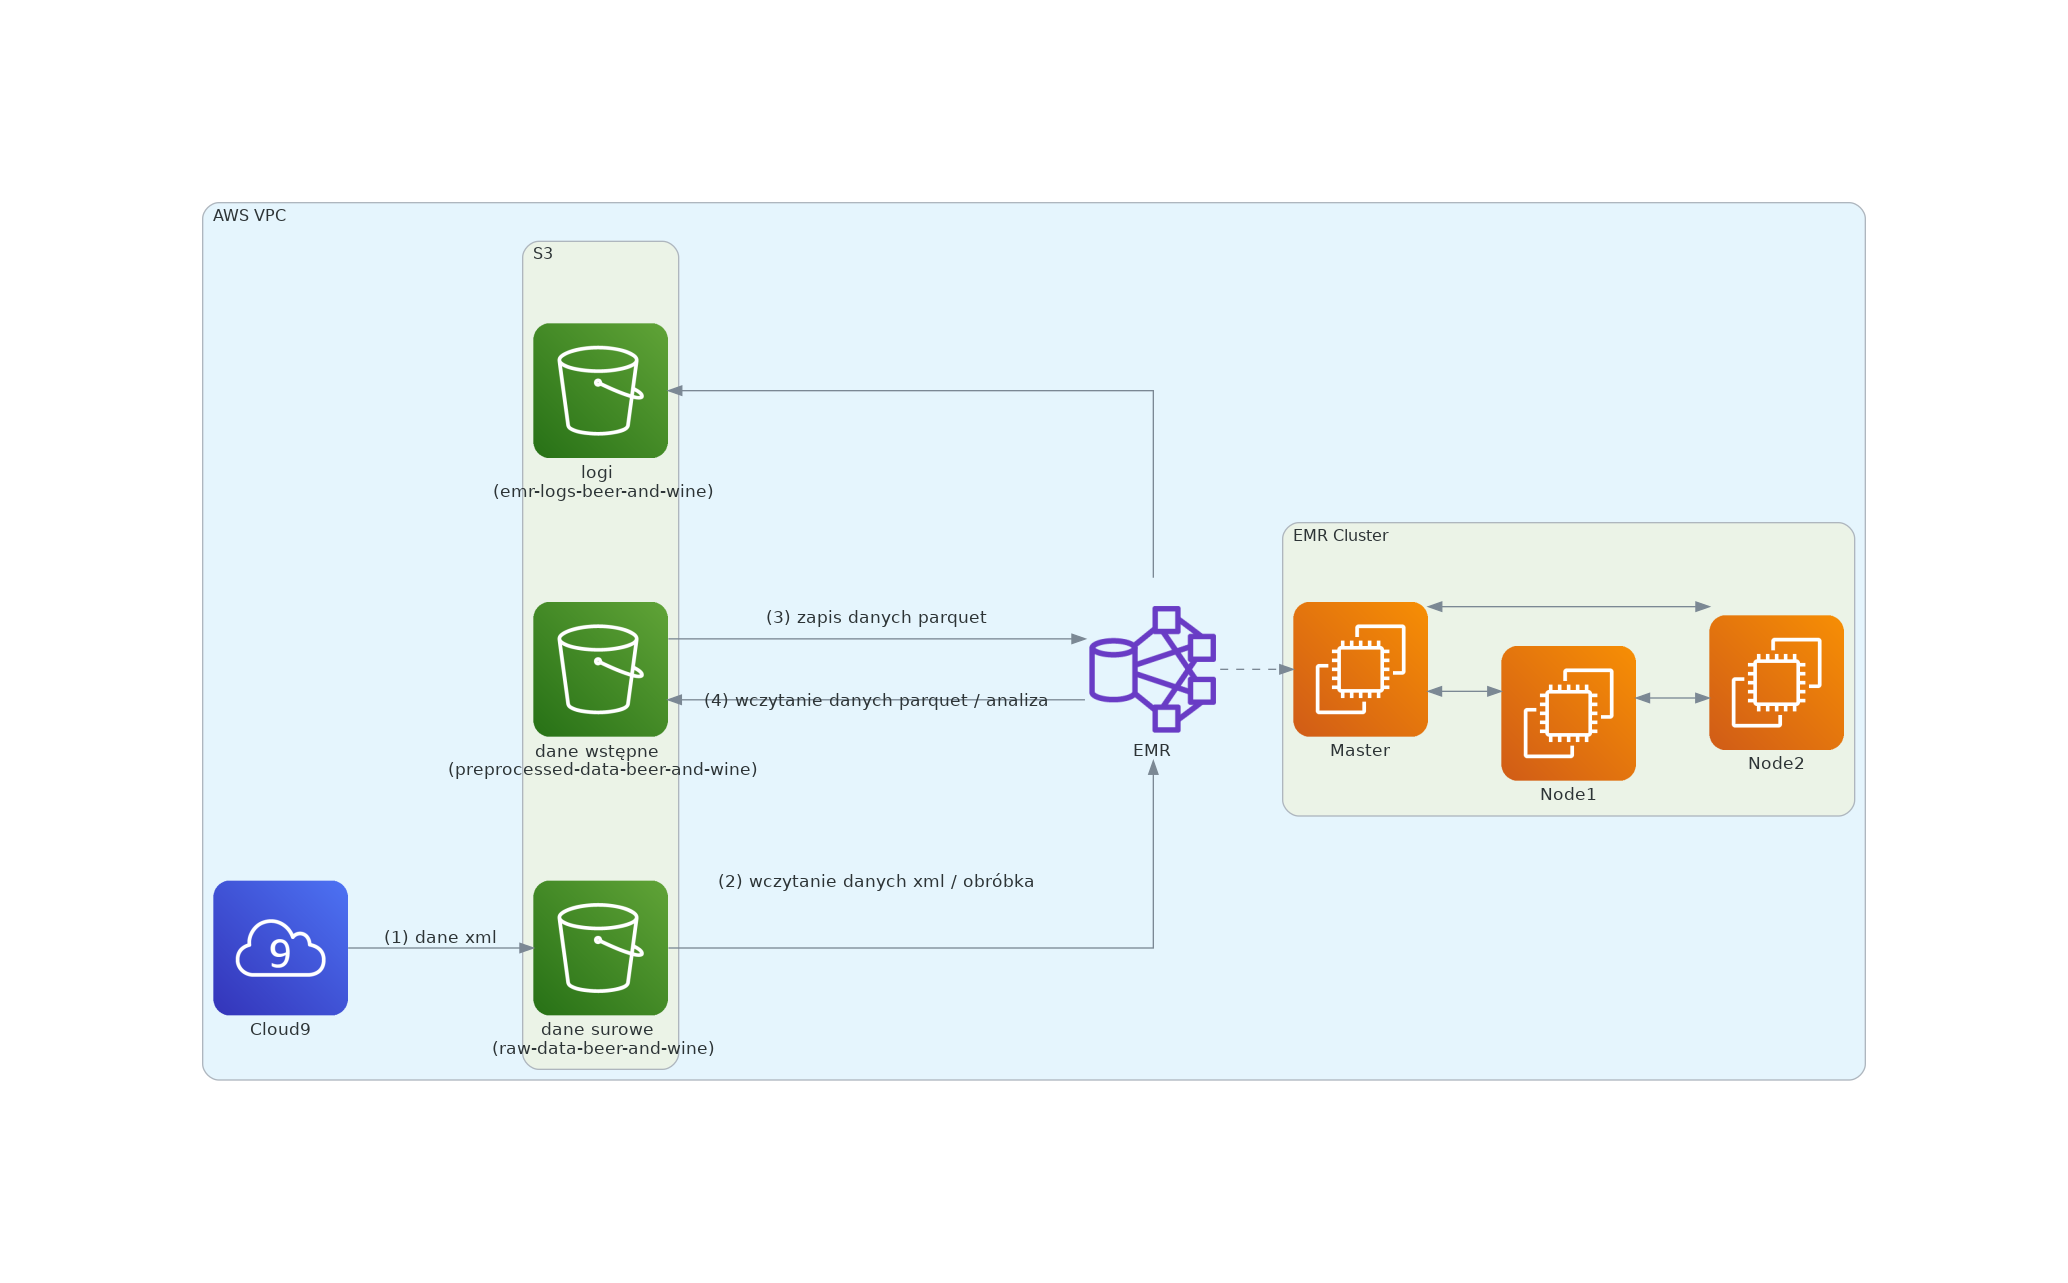

In [3]:
#| echo: false
#| label: fig-ryc1
#| fig-cap: "Schemat rozwiązania"

from diagrams import Node, Edge, Cluster, Diagram
from diagrams.aws.compute import EC2
from diagrams.aws.analytics import EMRCluster
from diagrams.aws.storage import S3
from diagrams.aws.devtools import Cloud9

with Diagram("") as diag:
    
    with Cluster("AWS VPC", direction="LR"):
        c9 = Cloud9("Cloud9") 
        emr = EMRCluster("EMR")

        with Cluster("S3"):
            raw = S3("dane surowe \n (raw-data-beer-and-wine)")
            prepro = S3("dane wstępne \n (preprocessed-data-beer-and-wine)")
            logs = S3("logi \n (emr-logs-beer-and-wine)")

        with Cluster("EMR Cluster"):
            master = EC2("Master")
            nodes =  [ec21 := EC2("Node1"), ec22 := EC2("Node2")]
            master >> Edge(reverse=True) >> nodes
            ec21 >> Edge(reverse=True) >> ec22

        c9 >> Edge(label="(1) dane xml") >> raw 

        raw >> Edge(label="(2) wczytanie danych xml / obróbka") >> emr
        emr >> Edge(label="(3) zapis danych parquet") >> prepro
        emr >> logs
        prepro >> Edge(label="(4) wczytanie danych parquet / analiza") >> emr
        emr >> Edge(style="dashed") >> master

diag

W celu rozwiązania postawionego problemu analitycznego stworzono infrastrukturę wyłącznie w obrębie chmury AWS, której ogólny schemat przedstawiono na @fig-ryc1

## Ekstrakcja

Do etapu ekstrakcji danych wykorzystano usługę `Cloud9`, która zapewnia dostęp do terminala maszyny wirtualnej z systemem linux (platforma `Amazon Linux 2`, typ instancji `t2.micro`). Z użyciem tej usługi dane zostały pobrane ze źródła w binarnym formacie `7z` a następnie pliki zostały wyekstrahowane w formacie `xml` przy pomocy programu `p7zip`. Dane w formacie `xml` zostały następnie skopiowane do serwisu `S3`, gdzie utworzono koszyk danych (ang. _bucket_) o nazwie `raw-data-beer-and-wine`, którego przeznaczeniem jest przetwymywanie danych nieprzetworzonych. 

Powyższe operacje zostały wykonane przy użyciu poniższych poleceń:

In [ ]:
#| eval: false
#| echo: true

# instalacja programu p7zip
sudo yum install p7zip.x86_64

# pobranie danych
wget https://archive.org/download/stackexchange/beer.stackexchange.com.7z

# ekstrakcja danych do folderu raw-data
7za e  beer.stackexchange.com.7z -oraw-data

# zapis danych do koszyka S3 przy użyciu programu `AWS CLI`
aws s3 cp $(pwd)/raw-data s3://raw-data-beer-and-wine/ --recursive  --include "*.xml"

## Przygotowanie danych wstępnych

W celu przygotowania danych do analizy, dane surowe zostały wstępnie przetworzone oraz zapisane w formacie `parquet`, co pozwoli na wydajniejsze wczytywanie danych podczas uruchomień programu. Podczas etapu wstępnego przetwarzania danych, oprócz zmiany formatu plików, zdefiniowane zostały także schematy danych, które zapewnią, że kolumny danych będą posiadały odpowiednie typy oraz, że krytyczne dane nie będą zawierały pustych wartości. Dodatkowo kolumny z wartościami tekstowymi, niesłownikowanymi zostały oczyszczone z tagów `html` oraz poddane standardowej procedurze oczyszania tekstu.

Powyższe czynności zostały wykonane w notatniku typu Jupiter (ang. _`Jupyter Notebook`_) w serwisie `AWS EMR`. Stworzono klaster `EMR` (wersja 6.8.0) z instalacją `Hadoop` 3.2.1, `Jupyter Hub` oraz `Spark` 3.3.0, składający się z 1 instancji typu _master_ oraz 2 instancji typu _core_, każda typu `m4.large`. W celu ograniczenia kosztów jako opcję zakupu wybrano typ `spot` z limitem maksymalnym ceny odpowiadającej typowi `on-demand`. Wielkość dysków `EBS` stworzonych instancji wynosiła 32 GiB dla każdej istancji w klastrze.

Polecenie programu AWS CLI odpowiadające za utworzenie klastra zajduje się w sekcji @sec-emr.

Dostęp do `Jupyter Notebook` w utworzonym klastrze jest możliwy poprzez połącznie przez przeglądarkę z środowiskiem graficznym `Jupyter Hub` wykorzystując adres DNS instancji _master_ i port 9443.

## Budowa infrastruktury

Wszystkie serwisy AWS na potrzeby tego projektu zostały utworzone w sposób programatyczny przy użyciu programu `AWS CLI` (poza `Cloud9`, który został utworzony z poziomu konsoli zarządzającej). Wykorzystane polecenia dostępne są w sekcji @sec-appendix. 